### FIFA 2019 - Prediction of player's sprint

Data from Kaggle: https://www.kaggle.com/karangadiya/fifa19

Model From: https://hackernoon.com/using-a-multivariable-linear-regression-model-to-predict-the-sprint-speed-of-players-in-fifa-19-530618986e1c


### Linear Regression

Linear Regression can be summed up as an attempt to model the relationship between one or multiple independent variables and a particular outcome or dependent variable. For this algorithm to be effective, there must be a linear relationship between the independent and dependent variables. Applied to data were a moderate to strong correlation exists between two or more variables it can be a very useful starting point in predicting the value of one outcome by finding the line that best fits/predicts an outcome.

## Y = MX + B

The math behind this is fairly simple, particularly where you are only looking at one independent variable. Y represents the outcome, or the dependent variable, while m denotes the slope, x the independent variable and b the y-intercept. Simply put, if you know the slope of the line and the value of the independent variable you can predict the outcome, assuming a linear relationship exists between x and y.

In my case however, I am going to be looking at multiple independent variables therefore the formula required changes slightly.

## F(x) = A +(B1*X1) +(B2*X2)+(B3*X3)+(B4*X4)...+(Bn*Xn)

With this formula I am assuming that there are (n) number of independent variables that I am considering. In this context F(x) is the predicted outcome of this linear model, A is the Y-intercept, X1-Xn are the predictors/independent variables, B1-Bn = the regression coefficients (comparable to the slope in the simple linear regression formula). Plugging the appropriate numbers in this formula would give me a prediction of an outcome, in this case the sprint speed of a player on FIFA19.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats  as stats

In [2]:
fifa_dataset = pd.read_csv("data.csv")
print(len(fifa_dataset))
fifa_dataset.head()

18207


,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


### Data Cleanup

I started off with a few assumptions, I assumed that sprint speed would be largely influenced by height, weight, age, acceleration stats and possibly the ratio between a player's weight and height. Upon observation of the data set I noticed that the heights and weights were recorded in string format (e.g 5'11 and 180lbs), additionally as someone who is more accustomed to the metric system I wanted to change these measurements to centimetres and kilograms respectively.

In [3]:
# Height: #inches to cms
fifa_dataset['Height'] = fifa_dataset.Height.str.replace("'",".").apply(lambda x: float(x)*30.48).dropna()
fifa_dataset['Height'] = fifa_dataset['Height'].fillna(fifa_dataset['Height'].mean()).astype(np.int64)

# Weight: #lbs to kg
fifa_dataset['Weight'] = fifa_dataset.Weight.str.replace("lbs", "").apply(lambda x: float(x)*0.453592).dropna()
fifa_dataset['Weight'] = fifa_dataset['Weight'].fillna(fifa_dataset['Weight'].mean()).astype(np.int64)


For weight, this conversion process involved splitting the string by looking for an apostrophe as a divider, replacing it with a full-stop(decimal separator) and applying a lambda function to convert the str to a float and converting it to centimetres. I converted the str to a float because I knew that the calculation would return a number that was essentially a float. After doing this I proceeded to fill all the NaN values with the mean height value in the dataframe and converted the number to an integer (under 100 rows). I made the assumption that filling in the missing values with a mean would be better for my analysis than forward filling, leaving out the NaN rows or changing them to zero. I later learnt that these columns would not be applicable to my analysis, however, I decided to include this to show the work I had to put in to clean some of the columns.

In [4]:
def func(x):
  x = x.fillna(x.mean()).astype(np.int64)
  return x
fifa_dataset[['Agility',
              'Acceleration',
              'Balance',
              'Positioning',
              'Skill Moves',
              'BallControl',
              'Crossing',
              'Finishing',
              'Reactions',
              'SprintSpeed']] = func(fifa_dataset[['Agility',
                                                   'Acceleration',
                                                   'Balance',
                                                   'Positioning',
                                                   'Skill Moves',
                                                   'BallControl',
                                                   'Crossing',
                                                   'Finishing',
                                                   'Reactions',
                                                   'SprintSpeed']])

In [5]:
len(fifa_dataset.columns)

89

After applying the same clean up to the height column, I defined a function that when applied to a column fills all NaN values with the mean of that column and converts the number to an int. After testing out which columns I would be using for my analysis, I applied this function to the relevant columns

### Testing Correlation and Significance testing

To test correlation between each column and the outcome column (sprintspeed) I opted to use the *spearmanr* function from the scipy package. This function calculates correlation and returns both the correlation between x and y and the p-value or the probability of the significance of this correlation.

In [8]:
#We want to test for moderate to strong correlations
def corr_test(x):
  x_corr = stats.spearmanr(x, fifa_dataset['SprintSpeed'])
  return x_corr
x = ['Agility',
              'Acceleration',
              'Balance',
              'Positioning',
              'Skill Moves',
              'BallControl',
              'Crossing',
              'Finishing',
              'Reactions',
              'SprintSpeed']
corr_test(fifa_dataset[x])

SpearmanrResult(correlation=array([[1.        , 0.79153744, 0.751638  , 0.63858244, 0.66787584,
        0.63660852, 0.64438283, 0.59401555, 0.26006604, 0.72943693,
        0.72943693],
       [0.79153744, 1.        , 0.66711078, 0.58999592, 0.62090294,
        0.54562254, 0.59987825, 0.5470081 , 0.15667498, 0.90652454,
        0.90652454],
       [0.751638  , 0.66711078, 1.        , 0.50694379, 0.55749696,
        0.51387245, 0.55876029, 0.46773141, 0.13223874, 0.58144115,
        0.58144115],
       [0.63858244, 0.58999592, 0.50694379, 1.        , 0.76278208,
        0.80501402, 0.68412627, 0.87357924, 0.44351901, 0.56764472,
        0.56764472],
       [0.66787584, 0.62090294, 0.55749696, 0.76278208, 1.        ,
        0.82401101, 0.70271508, 0.72392405, 0.37300797, 0.58469363,
        0.58469363],
       [0.63660852, 0.54562254, 0.51387245, 0.80501402, 0.82401101,
        1.        , 0.7687287 , 0.73703736, 0.56817613, 0.51898068,
        0.51898068],
       [0.64438283, 0.59987825

Using this function I ran through different columns in my dataset to determine which columns I would be using for my regression model. I opted to use columns where a moderate to strong correlation of at-least 0.50 (or under -0.50) existed. Using this as a benchmark I ended up with the columns; Agility, Acceleration, Balance, Positioning, Skill Moves, Ball Control, Crossing, Finishing and Reactions- these are the independent variables.

### Multivariate Linear Regression Model

In [9]:
#multivariate linear regression
#80/20 split- 20% training data
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
train, test = train_test_split(fifa_dataset, test_size=0.2)

My machine learning algorithm (assuming you consider a linear regression model machine learning) relied heavily on the sklearn library. After importing this library, I opted to apply the 80/20 rule in splitting my data between training and test data, with 20% of the data falling under training data. I reasoned that I did not want to use more than 20% in order to get more certainty that my model could be generalised to the entire database.

In [10]:
#independent and dependent variables
features= ['Agility', 'Acceleration', 'Balance','Reactions','Positioning','Skill Moves','BallControl','Crossing','Finishing']
target = 'SprintSpeed'
#define model I am using
model = LinearRegression()
#training process
model.fit(train[features], train[target])
#mean absolute value for training data
data = train[target]
predict =  model.predict(train[features])
training_error = mean_absolute_error(data, predict)
#mean absolute value for test data
test_data = test[target]
predict_test = model.predict(test[features])
test_data_error = mean_absolute_error(test_data, predict_test)

I went on to define the features I would be using for this model (the independent variables) and the target or the variable I sought to predict (the dependant variable) then proceeded to train the model using the linear regression model. Training involved looking at the correlation between the independent and dependant variables to make calculations that would enable the model to predict outcomes from the test data.

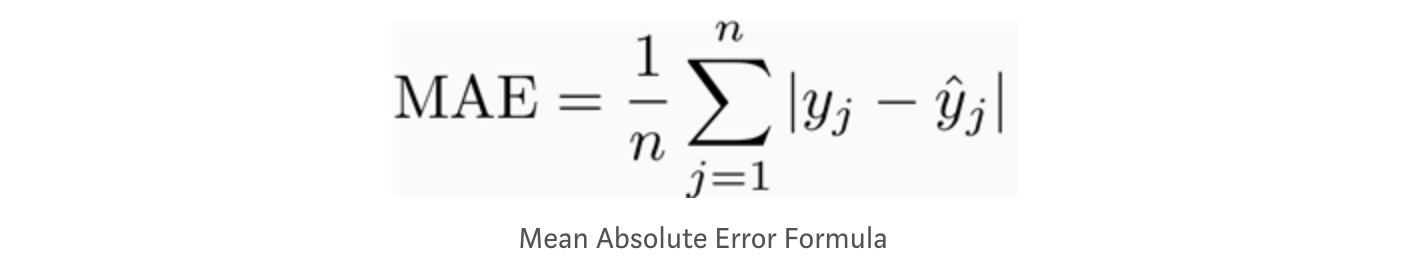

In [12]:
from IPython.display import Image, display
display(Image(filename="mean_absolute_error.png", embed=True))

To test the forecasting errors (loss function) in the data I calculated the mean absolute error (MAE) using the metrics module n sklearn for both the training and test data. In this formula n represents the number of errors in the data, Σ simply means summation and |yj — ŷj| refers to the absolute errors observed from the predictions. The formula sums the absolute errors and divides them by the total number of instances giving me a figure showing me what the average error between the predicted and actual sprint speed.

I would ideally want the number to be as small as possible and report that figure together with my prediction success rate. I could have alternatively open to use the root mean squared error (RMSE) similar to the MAE this would return a figure showing the deviation of the predicted values from the predictions. RMSE simply finds the square root of the MAE figure (however we would square the absolute errors in this instance).